In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular import *
from fastai import *

## Looking at sample data

In [3]:
path = Path('/mnt/datadrive1/h216520/fastai_v3/data/PUBG'); path

PosixPath('/mnt/datadrive1/h216520/fastai_v3/data/PUBG')

In [4]:
# import feather
pubsamp = pd.read_feather(f'{path}/train_V2')
pubsamp_test = pd.read_feather(f'{path}/test_V2')

In [5]:
pubsamp.loc[pubsamp.winPlacePerc.isna(), 'winPlacePerc'] = pubsamp.winPlacePerc.median()

In [6]:
pubsamp[pubsamp.winPlacePerc.isna()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc


## Model Pre Steps

### Iter1 with less categorical variables

In [7]:
dep_var = 'winPlacePerc'
cont_names = ['assists', 'boosts', 'damageDealt', 'DBNOs','headshotKills', 'heals',  'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration',  'numGroups', 'rankPoints', 'revives', 'maxPlace',
    'rideDistance', 'roadKills','swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance','weaponsAcquired', 'winPoints', 'killPlace']
cat_names = ['matchType']
procs = [FillMissing, Categorify, Normalize]

data = (TabularList.from_df(pubsamp, cat_names=cat_names, cont_names=cont_names, procs=procs, path=path)
        .split_by_idx(list(np.random.permutation(pubsamp.shape[0]))[:int(pubsamp.shape[0]*.15)])
        .label_from_df(cols=dep_var, label_cls=FloatList)
        .add_test(pubsamp_test)#, label=0)
        .databunch())

In [8]:
data.show_batch(10);data.show_batch(10, ds_type=DatasetType.Valid)

matchType,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPoints,kills,killStreaks,longestKill,matchDuration,numGroups,rankPoints,revives,maxPlace,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,killPlace,target
squad-fpp,-0.3975,-0.6453,-0.1798,0.2987,1.2869,-0.5112,-0.8048,0.0486,0.6417,-0.3584,-0.5004,-0.6443,0.8254,-0.3487,-0.6506,-0.4044,-0.0476,-0.1480,-0.1424,-0.0855,-0.9548,-0.6765,-0.8199,-0.3133,0.0357000008225441
squad,-0.3975,-0.0622,-0.0984,1.1716,-0.3773,-0.5112,1.3624,0.6909,0.6417,-0.2292,-0.8830,-0.6013,-1.2122,-0.3487,-0.6506,-0.4044,-0.0476,-0.1480,-0.1424,-0.0855,0.9520,0.1388,1.2633,-1.0051,0.821399986743927
duo-fpp,-0.3975,2.2704,1.8528,2.0446,1.2869,4.7119,-0.8048,3.2602,2.0485,2.1843,0.9683,0.1718,0.8715,-0.3487,0.2311,-0.4044,-0.0476,-0.1480,-0.1424,-0.0855,3.1750,0.1388,-0.8199,-1.6606,0.8367000222206116
solo,-0.3975,-0.6453,-0.7658,-0.5743,-0.3773,-0.5112,0.8668,-0.5938,-0.7651,-0.4511,-0.3844,1.9759,-1.2122,-0.3487,2.0363,-0.4044,-0.0476,-0.1480,-0.1424,-0.0855,-0.9331,-1.0841,1.2362,0.8884,0.23909999430179596
solo-fpp,-0.3975,-0.0622,-0.3538,-0.5743,-0.3773,-0.5112,-0.8048,-0.5938,-0.7651,-0.4511,1.3162,2.2336,0.8132,-0.3487,2.2462,0.3521,-0.0476,-0.1480,-0.1424,-0.0855,0.4806,0.5464,-0.8199,0.0509,0.680400013923645
squad,-0.3975,1.1041,-0.7658,-0.5743,-0.3773,0.9811,1.2748,-0.5938,-0.7651,-0.4511,-1.2966,-0.6872,-1.2122,1.7705,-0.6926,-0.1779,-0.0476,-0.1480,-0.1424,-0.0855,1.6634,0.1388,1.2592,-0.0948,0.8148000240325928
squad-fpp,-0.3975,-0.6453,-0.1212,1.1716,-0.3773,-0.5112,0.8907,-0.5938,-0.7651,-0.4511,-0.7787,-0.7302,-1.2122,-0.3487,-0.6926,-0.4044,-0.0476,-0.1480,-0.1424,-0.0855,-0.7670,-1.0841,1.2268,1.2889,0.14810000360012054
squad-fpp,-0.3975,-0.6453,0.1770,0.2987,-0.3773,-0.5112,-0.8048,0.0486,0.6417,-0.3393,1.2041,-0.6443,0.8512,-0.3487,-0.6926,-0.4044,-0.0476,-0.1480,-0.1424,-0.0855,-0.5533,-0.2688,-0.8199,-0.4589,0.14810000360012054
squad-fpp,1.3022,-0.0622,-0.4828,-0.5743,-0.3773,-0.1381,-0.8048,-0.5938,-0.7651,-0.4511,1.0533,-0.6013,0.7887,1.7705,-0.6506,-0.4044,-0.0476,-0.1480,-0.1424,-0.0855,-0.6452,-0.2688,-0.8199,1.0705,0.2856999933719635
squad-fpp,-0.3975,-0.6453,0.4419,0.2987,-0.3773,-0.5112,1.6015,0.0486,0.6417,-0.3702,-1.0531,-0.6443,-1.2122,-0.3487,-0.6506,-0.4044,-0.0476,-0.1480,-0.1424,-0.0855,-0.9510,-1.0841,1.2038,-0.2040,0.0


matchType,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPoints,kills,killStreaks,longestKill,matchDuration,numGroups,rankPoints,revives,maxPlace,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,killPlace,target
duo-fpp,-0.3975,-0.6453,-0.7658,-0.5743,-0.3773,-0.5112,-0.8048,-0.5938,-0.7651,-0.4511,0.9876,0.1289,0.7806,-0.3487,0.1891,-0.4044,-0.0476,-0.1480,-0.1424,-0.0855,-0.4564,-1.0841,-0.8199,0.9612,0.33329999446868896
duo,1.3022,-0.6453,0.0223,-0.5743,-0.3773,-0.5112,-0.8048,-0.5938,-0.7651,-0.4511,1.1964,0.2148,0.7887,-0.3487,0.1891,-0.4044,-0.0476,-0.1480,-0.1424,-0.0855,-0.7019,0.9541,-0.8199,1.1069,0.25
squad,1.3022,-0.0622,0.1999,-0.5743,-0.3773,-0.5112,-0.8048,-0.5938,-0.7651,-0.4511,0.9722,-0.7732,0.8376,-0.3487,-0.7345,0.1269,-0.0476,-0.1480,-0.1424,-0.0855,1.6601,0.5464,-0.8199,0.3786,0.6538000106811523
squad-fpp,3.0018,0.5210,-0.2061,-0.5743,-0.3773,-0.1381,1.7035,-0.5938,-0.7651,-0.4511,1.5906,-0.6443,-1.2122,-0.3487,-0.6086,1.1193,-0.0476,-0.1480,-0.1424,-0.0855,1.8485,1.7693,1.4796,-0.2040,0.965499997138977
squad,-0.3975,-0.6453,0.1788,0.2987,-0.3773,-0.1381,-0.8048,0.0486,0.6417,-0.2634,-0.4540,-0.7732,0.8227,-0.3487,-0.7345,-0.4044,-0.0476,-0.1480,-0.1424,-0.0855,-0.8549,0.1388,-0.8199,-0.3133,0.11540000140666962
duo-fpp,-0.3975,-0.6453,-0.3234,-0.5743,-0.3773,-0.5112,-0.8048,0.0486,0.6417,-0.4258,-0.7632,0.1289,0.7602,-0.3487,0.0631,-0.4044,-0.0476,-0.1480,-0.1424,-0.0855,-0.6991,-0.2688,-0.8199,-0.5317,0.4666999876499176
squad,1.3022,2.2704,-0.6182,-0.5743,-0.3773,-0.1381,-0.8048,-0.5938,-0.7651,-0.4511,-0.1216,-0.8591,0.7684,-0.3487,-0.7345,-0.4044,-0.0476,-0.1480,-0.1424,-0.0855,1.1962,0.9541,-0.8199,-0.0948,0.9230999946594238
solo,-0.3975,-0.6453,-0.7658,-0.5743,-0.3773,-0.5112,-0.8048,-0.5938,-0.7651,-0.4511,0.8833,-1.7611,0.8254,-0.3487,-1.1124,-0.4044,-0.0476,-0.1480,-0.1424,-0.0855,-0.9752,-1.0841,-0.8199,-1.2964,0.0
squad-fpp,-0.3975,0.5210,-0.7658,-0.5743,-0.3773,-0.5112,-0.8048,-0.5938,-0.7651,-0.4511,0.9258,-0.7732,0.7847,-0.3487,-0.6926,2.7372,-0.0476,-0.1480,-0.1424,-0.0855,0.1190,0.9541,-0.8199,0.4150,0.44440001249313354
normal-duo-fpp,-0.3975,3.4367,-0.7658,-0.5743,-0.3773,1.3542,-0.8048,-0.5938,-0.7651,-0.4511,-2.2667,-1.5034,0.8254,-0.3487,-1.5322,0.5050,-0.0476,-0.1480,-0.1424,-0.0855,0.5735,1.3617,-0.8199,-1.4057,0.7142999768257141


In [9]:
y_range = torch.tensor([-0.2,1.2], device=defaults.device)
print(y_range)

def mae(pred:Tensor, targ:Tensor)->Rank0Tensor:
    "Exp RMSE between `pred` and `targ`."
    error = (pred - targ).abs()
    return error.mean()

# learn = tabular_learner(data, layers=[1000, 500, 250], ps=[0.001,0.01, 0.1], emb_drop=0.04, y_range=y_range, metrics=mae)
learn = tabular_learner(data, layers=[1000, 500], ps=[0.001, 0.01], emb_drop=0.04, y_range=y_range, metrics=mae)

tensor([-0.2000,  1.2000], device='cuda:0')


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


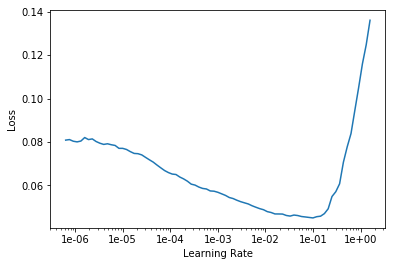

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,mae
1,0.009674,0.008729,0.337013
2,0.008299,0.007584,0.341913
3,0.008002,0.007531,0.335657
4,0.007515,0.006982,0.338035
5,0.007968,0.007043,0.336299


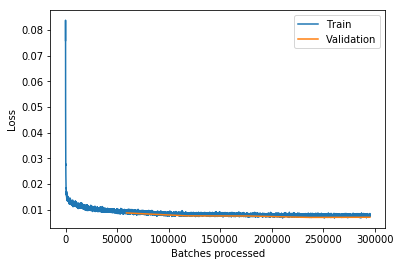

In [12]:
learn.recorder.plot_losses()

### With most categorical vars

In [14]:
dep_var = 'winPlacePerc'
cont_names = [ 'damageDealt', 'killPoints', 'longestKill', 'rankPoints', 
              'rideDistance', 'swimDistance',  'walkDistance', 'winPoints']
cat_names = ['killPlace', 'matchType', 'maxPlace', 'assists', 'boosts','DBNOs','headshotKills', 'heals','kills',
            'killStreaks', 'matchDuration',  'numGroups', 'revives', 'roadKills','teamKills', 'vehicleDestroys',
            'weaponsAcquired']
procs = [FillMissing, Categorify, Normalize]

data = (TabularList.from_df(pubsamp, cat_names=cat_names, cont_names=cont_names, procs=procs, path=path)
        .split_by_idx(list(np.random.permutation(pubsamp.shape[0]))[:int(pubsamp.shape[0]*.15)])
        .label_from_df(cols=dep_var, label_cls=FloatList)
#         .add_test(pubsamp_test, label=0)
        .databunch())

In [15]:
y_range = torch.tensor([0,1.1], device=defaults.device)
print(y_range)

def mae(pred:Tensor, targ:Tensor)->Rank0Tensor:
    "Exp RMSE between `pred` and `targ`."
    error = (pred - targ).abs()
    return error.mean()

learn = tabular_learner(data, layers=[1000, 500], ps=[0.001,0.01], emb_drop=0.04, y_range=y_range, metrics=mae)

tensor([0.0000, 1.1000], device='cuda:0')


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


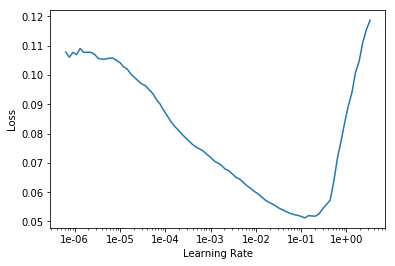

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,mae
1,0.007889,0.007629,0.342187
2,0.006472,0.007503,0.341565
3,0.006388,0.006934,0.343087
4,0.006336,0.007014,0.343805
5,0.005855,0.007237,0.343031
